In [1]:
from hdrh.histogram import HdrHistogram
import seaborn as sns
import pandas
from matplotlib import pyplot as plt
import os.path
from enum import Enum
import matplotlib as mpl
from typing import *

To generate the dumps, do something like this
```fish
for GC in Serial Parallel G1 Z Shenandoah; taskset -c 0-7 /usr/lib/jvm/temurin-17-amd64/bin/java -server -XX:-TieredCompilation -Xcomp -XX:+UnlockExperimentalVMOptions -XX:+Use{$GC}GC -XX:ConcGCThreads=4 -XX:ParallelGCThreads=4 -Xms420M -Xmx420M -jar /usr/share/benchmarks/dacapo/dacapo-evaluation-git-29a657f.jar -n 5 lusearch -t 4 --dump-latency; mv scratch scratch-$GC; end
```

In [2]:
class LatencyType(Enum):
    METERED = 'metered'
    SIMPLE = 'simple'

LATENCY_TYPE = LatencyType.METERED


RUNID = 'elk-2022-03-05-Sat-172437'
HFAC = 3023
HEAP = {
    'lusearch': 70,
    'cassandra': 269,
    'h2':  3489,
    'tomcat': 76,
}
DACAPO = 'dacapochopin-29a657f'


# SAVE_FILE = 'pdf'
# SAVE_FILE = 'jpg'
SAVE_FILE = None


DATA = {
    'LXR': '{runid}/{bench}.{hfac}.{heap}.jdk-lxr-old.ix.common.tph.mmtk_perf.nr-1.latency.{dacapo}',
    'G1': '{runid}/{bench}.{hfac}.{heap}.jdk-lxr-old.g1.common.hs_perf.latency.{dacapo}',
    'Shen.': '{runid}/{bench}.{hfac}.{heap}.jdk-lxr-old.shenandoah.common.hs_perf.latency.{dacapo}',
    'ZGC': '{runid}/{bench}.{hfac}.{heap}.jdk-lxr-old.z.common.hs_perf.latency.{dacapo}',
}
MAX_INVOCATIONS = 40
MIN_LATENCY_USEC = 1
MAX_LATENCY_USEC = 1000 * 1000 # 1 sec
LATENCY_SIGNIFICANT_DIGITS = 5

In [3]:
def load_data(invocation: int, latency_type: LatencyType, folder: str):
    path = os.path.realpath(os.path.expanduser('{}.{}/dacapo-latency-usec-{}.csv'.format(folder, invocation, latency_type.value)))
    if not os.path.isfile(path):
        return None
    df =  pandas.read_csv(path, names=["start", "end"])
    df["latency"] = df["end"] - df["start"]
    return df

def load_data_and_plot(bench, data: Optional[Dict[str, Union[str, List[str]]]] = None, invocations = MAX_INVOCATIONS, save = SAVE_FILE, latency_type: LatencyType = LATENCY_TYPE):
    assert bench in HEAP
    print(f'[{bench}] Loading...')
    histograms = {}
    # Clean up inputs
    if data is None:
        data = { k: v for k, v in DATA.items() }
    for gc in data.keys():
        if isinstance(data[gc], str):
            data[gc] = [ data[gc] ]
        data[gc] = [
            f'~/MMTk-Dev/evaluation/results/log/{x}'.format(runid=RUNID, bench=bench, hfac=HFAC, heap=HEAP[bench], dacapo=DACAPO)
            for x in data[gc]
        ]
    data: Dict[str, List[str]]
    # Load data
    for gc, logs in data.items():
        histograms[gc] = []
        for folder in logs:
            for i in range(invocations):
                loaded_data = load_data(i, latency_type, folder)
                if loaded_data is None:
                    continue
                histogram = HdrHistogram(MIN_LATENCY_USEC, MAX_LATENCY_USEC, LATENCY_SIGNIFICANT_DIGITS)
                latencies = loaded_data["latency"]
                for l in latencies:
                    histogram.record_value(l)
                histograms[gc].append(histogram)
    # Process data
    print(f'[{bench}] Processing...')
    percentile_list = []
    for gc, hists in histograms.items():
        for j, histogram in enumerate(hists):
            for i in histogram.get_percentile_iterator(5):
                percentile_list.append({"GC": gc, "inv": j, "value": i.value_iterated_to, "percentile": i.percentile_level_iterated_to / 100})
    percentile_df = pandas.DataFrame(percentile_list)
    percentile_df["other"] = 1 / (1 - percentile_df["percentile"])
    # Plot curves
    print(f'[{bench}] Plotting...')
    fig, ax = plt.subplots(1,1,figsize=(16,12))
    # fig.suptitle(f'{bench} {latency_type} latency')
    sns.color_palette()
    # colors = ['green', 'blue', 'orange', 'red'][:len(gcs)]
    # print(f'{gcs} {colors}')
    sns.lineplot(data=percentile_df, x="other", y="value", hue="GC")
    # sns.lineplot(data=percentile_df, x="other", y="value", hue="GC")
    ax.set_xscale('log')
    ax.set_xlabel('Percentile', fontsize=26, labelpad=12)
    ax.set_ylabel('Latency (msec)', fontsize=26, labelpad=12)
    ax.set_xticks([1, 10, 100, 1000, 10000, 100000, 1000000])
    ax.set_xticklabels(['0', '90', '99', '99.9', '99.99', '99.999', '99.9999'], fontsize=20)
    plt.yticks(fontsize=20)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: f'{int(x / 1000)}'.format(x)))
    plt.legend(fontsize=26)

    if save is not None:
        print(f'[{bench}] Save to latency-{bench}.{save}')
        plt.savefig(f'latency-{bench}.{save}', bbox_inches='tight')

# lusearch

[lusearch] Loading...
[lusearch] Processing...
[lusearch] Plotting...


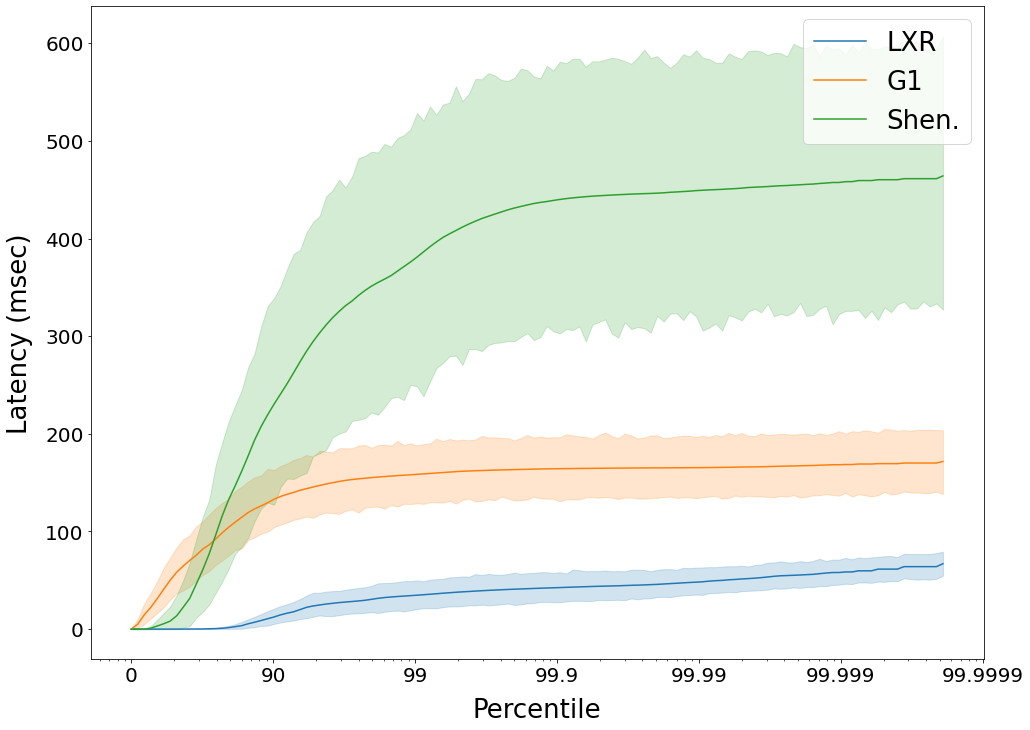

In [4]:
load_data_and_plot(bench = 'lusearch')

# cassandra

[cassandra] Loading...
[cassandra] Processing...
[cassandra] Plotting...


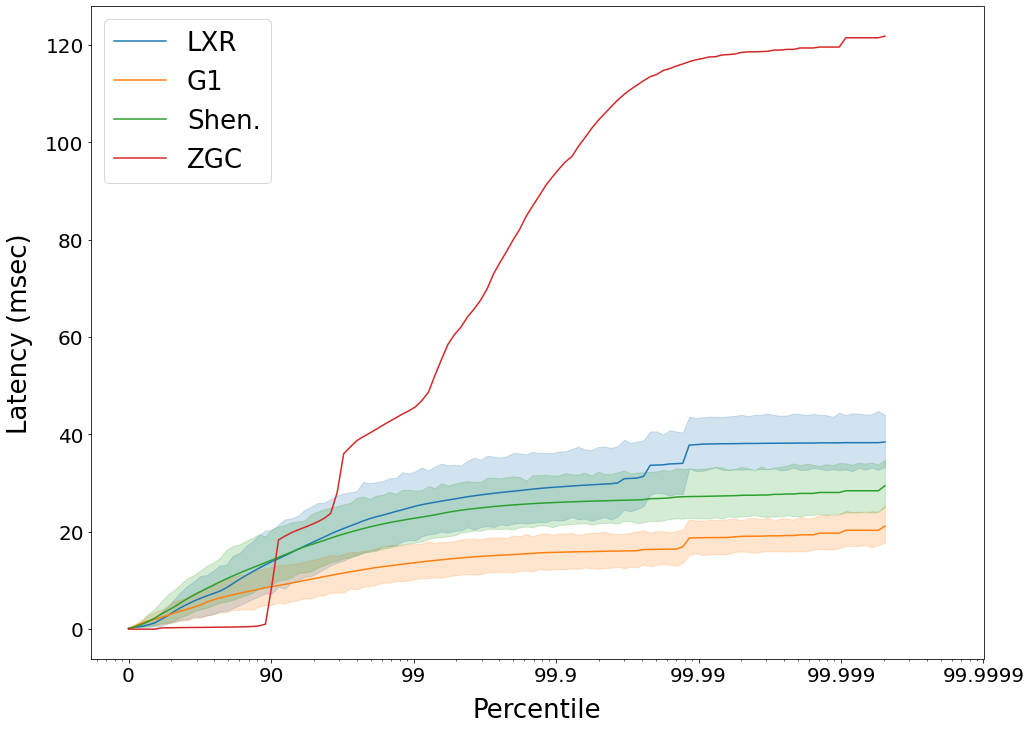

In [5]:
load_data_and_plot(bench = 'cassandra')

# h2

[h2] Loading...
[h2] Processing...
[h2] Plotting...


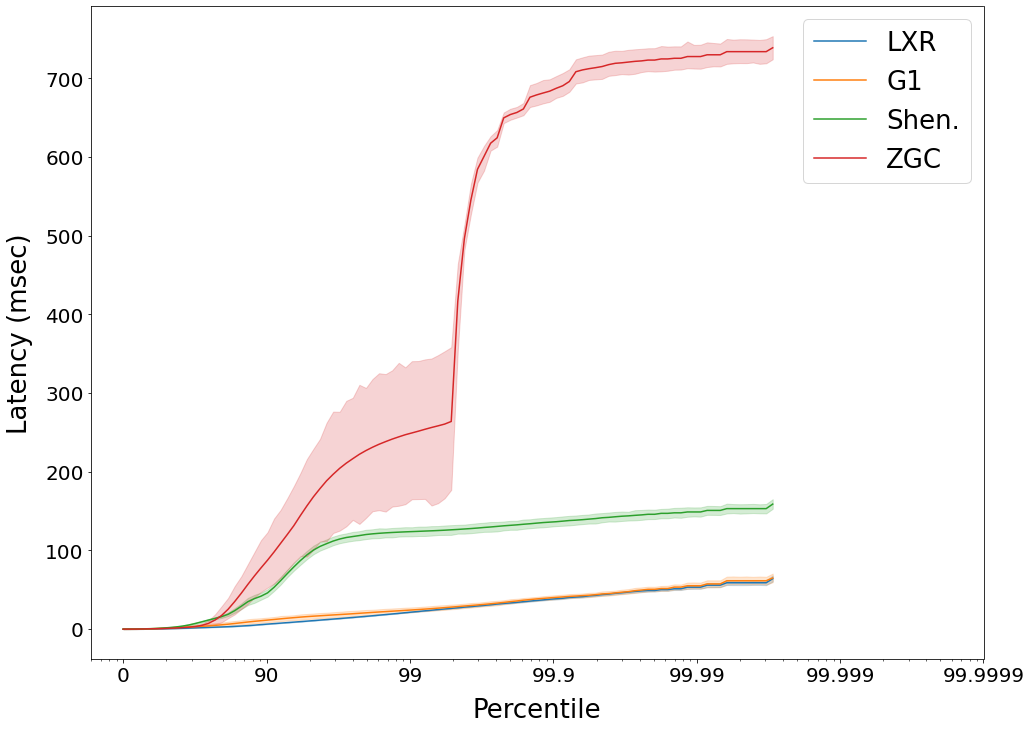

In [6]:
load_data_and_plot(bench = 'h2')

# tomcat

[tomcat] Loading...
[tomcat] Processing...
[tomcat] Plotting...


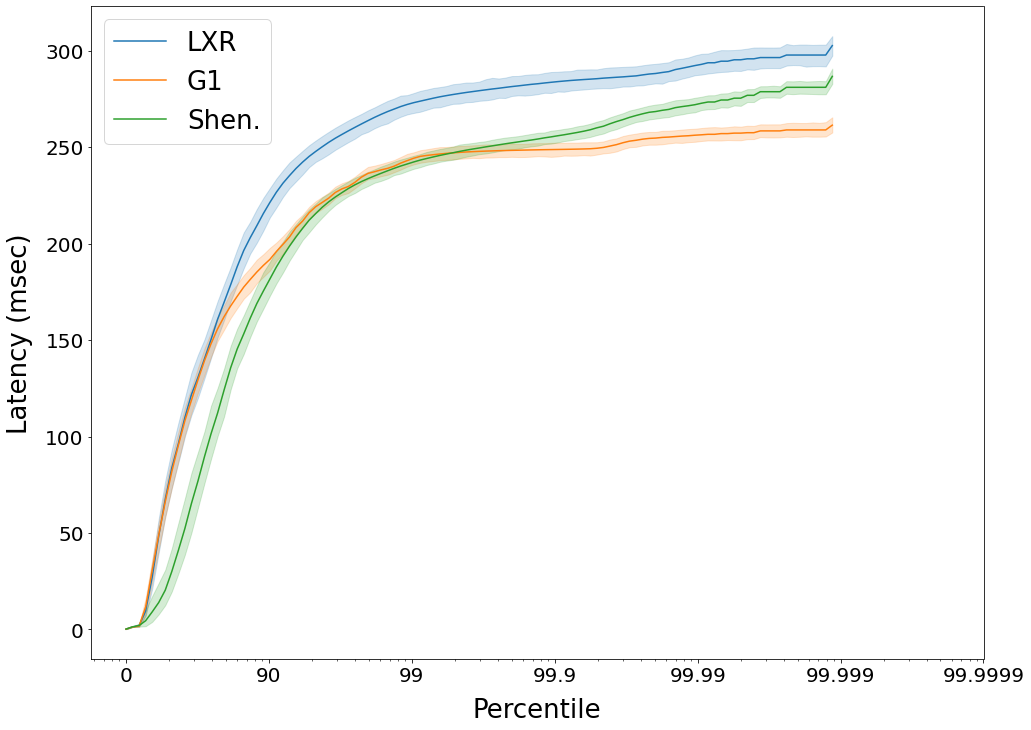

In [7]:
load_data_and_plot(bench = 'tomcat')